# Projektarbeit Weather Forecast
1. Daten Filtern und Aufbereiten
2. Besten Parameter für den Random Forest
3. Ergebnis Analysieren

In [1]:
# Import der Bibliotheken
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

## Daten Laden
-
Zunächst laden wir die csv dateien in ein Pandas Dataframe auf dem die Daten im preprocessing verarbeitet werden können.
Anschließend definieren wir eine Funktion `filter_columns`.
Diese Funktion ermöglicht die Transformation von Daten in einem Pandas DataFrame der Daten, 
wobei zeitabhängige Verzögerungen und Varianten für bestimmte Spalten berücksichtigt werden. Die Funktion erfordert folgende Parameter:

- `columns`: Eine Liste von Spalten, die für die zeitabhängigen Varianten verwendet werden sollen, einschließlich der Zielspalte.
- `variants`: Die Anzahl der gewünschten zeitlichen Varianten.
- `extras`: Eine Liste der Zielspalten, für die eine spezielle zeitliche Variante die abhähngig der `variants` und `timelag` in der Zukunft liegt.
- `selected_pass`: Eine optionale Liste von Spalten, die unverändert bleiben sollen und ohne Kopien oder zeitliche Verschiebungen durch die Funktion durchgeschleust werden.
- `timelag`: Ein optionaler Parameter, der die zeitliche Verzögerung für ausgewählte Spalten festlegt in `extras` zu den ersten Daten gibt.

Die Funktion erstellt für die angegebenen Spalten zeitabhängige Varianten entsprechend der definierten Varianten und Verschiebungen. Zusätzlich werden spezielle Varianten für die in extras aufgeführten Zielspalten erstellt, wobei eine zusätzliche zeitliche Verschiebung durch timelag erfolgt. Der resultierende DataFrame wird zurückgegeben, wobei die in selected_pass aufgeführten Spalten unverändert bleiben.

In [2]:
straubingDaten = pd.read_csv("../Daten/Straubing.csv")
arberDaten = pd.read_csv("../Daten/Arber.csv")
schorndorfDaten = pd.read_csv("../Daten/Schorndorf.csv")

In [3]:
def filter_columns(df, columns, variants=3, extras=None, selected_pass=None, timelag=0):
    if extras is None:
        extras = []
    if selected_pass is None:
        selected_pass = []
    
    # suffix für die spalten hinzufügen
    df = df.rename(columns=lambda x: f'{x}_0' if x not in selected_pass else x)

    # spalten kopieren und schiften um 1
    for v in range(1, variants + 1):
        for i in range(len(columns)):
            df[f'{columns[i]}_{v}'] = df[f'{columns[i]}_{v-1}'].shift(-1, fill_value=-999)
            if columns[i] in extras and v == variants:
                df[f'{columns[i]}_{v+1}'] = df[f'{columns[i]}_{v}'].shift(-1-timelag, fill_value=-999)

    # Alles wieder zusammensetzen
    columns_with_variants = [f'{col}_{v}' for col in columns for v in range(0, variants + 1)] + [f'{col}_{variants+1}' for col in extras]
    df_filtered = df[selected_pass + columns_with_variants]

    # 
    return df_filtered

### Configuration zur Filterung
Zunächst wird die Filterung Configuriert:
- `selected_columns`: Eine Liste von Spalten, die für die zeitabhängigen Varianten verwendet werden sollen, einschließlich der Zielspalte.
- `selected_result`: Eine Liste der Zielspalten.
- `selected_pass`: Eine Liste an Spalten die keinen lediglich zum joinen von den drei datensätzen ist, diese Spalten werden später wieder rausgenommen.
- `vergangenheit`: Der Vergangenheitswert gibt an wie weit in die vergangenheit die Daten mitgenommen wird.
- `timelag`: Der Timelag gibt an wie weit in der zukunft die Prognose liegen muss, abhängig vom neuesten Datensatz.

In [4]:
selected_columns = ['LUFTTEMPERATUR', 'DAMPFDRUCK', 'NIEDERSCHLAGSHOEHE', 'NIEDERSCHLAGSHOEHE_IND', 'SCHNEEHOEHE']
selected_result = ['LUFTTEMPERATUR']
selected_pass = ['MESS_DATUM']
vergangenheit=5
timelag = 3

### Filterung
Jetzt werden die einzelnen Daten gefiltert und gejoint.
Dabei wird für jeden Datensatz zunächst der die Verschiebungen der Zeit vorhergenommen und anschließend ein prefix hinzugefügt.
Der Join ist ein full outer join der alle datensätze miteinander anhand der Spalte `MESS_DATUM` gejoint.
Die Felder die übrich geblieben sind werden mit `-999` aufgefüllt.
Die jeweiligen Spalten zum joinen werden jetzt nicht mehr gebraucht und werden gelöscht.
Anschließend werden alle datensätze gelöscht, in denen Daten fehlen.
Als ausgabe kann man sehen, wo und welche daten gelöscht werden.
Zulätzt werden noch die Featcher und Ziel spalten voneinander getrennt

In [5]:
# Zeitverschiebungen hinzugefügt
straubingDatenFiltered = filter_columns(straubingDaten, selected_columns, variants=vergangenheit, extras=selected_result, selected_pass=selected_pass, timelag=timelag)
arberDatenFiltered = filter_columns(arberDaten, selected_columns, variants=vergangenheit, extras=[], selected_pass=selected_pass, timelag=timelag)
schorndorfDatenFiltered = filter_columns(schorndorfDaten, selected_columns, variants=vergangenheit, extras=[], selected_pass=selected_pass, timelag=timelag)

# Prefixes hinzugefügt
straubingDatenFiltered = straubingDatenFiltered.add_prefix('straubing_')
arberDatenFiltered = arberDatenFiltered.add_prefix('arber_')
schorndorfDatenFiltered = schorndorfDatenFiltered.add_prefix('schorndorf_')

# Ausgabe der Länge der einzelnen Datensätze
print(f'Länge des Straubing Datensatzes: {len(straubingDatenFiltered)}')
print(f'Länge des Arber Datensatzes: {len(arberDatenFiltered)}')
print(f'Länge des Schorndorf Datensatzes: {len(schorndorfDatenFiltered)}')
print('#################')

# Merging der Einzelnen Datensätze zu einem neuen (allDatenFiltered)
allDatenFiltered = pd.merge(straubingDatenFiltered, arberDatenFiltered, how='outer', left_on='straubing_MESS_DATUM', right_on='arber_MESS_DATUM').merge(schorndorfDatenFiltered, how='outer', left_on='straubing_MESS_DATUM', right_on='schorndorf_MESS_DATUM')
allDatenFiltered = allDatenFiltered.fillna(-999)
allDatenFiltered = allDatenFiltered.drop(columns=['straubing_MESS_DATUM', 'arber_MESS_DATUM', 'schorndorf_MESS_DATUM'])

# Ausgabe der zu löschenden Daten und diese dann auch gelöscht
# Hier wird noch ein unterschied für die prefixes gemacht, dies ist nur noch aus lagacy gründen drinnen
preflen = len(allDatenFiltered)
pd.set_option('display.max_rows', None)
print(f'Anzahl wie viele daten in einer Spalte Fehlen:\n{(allDatenFiltered == -999).sum()}')
pd.reset_option('display.max_rows')
for prefix in ['straubing_', 'arber_', 'schorndorf_']:
    mask = allDatenFiltered.columns.str.startswith(prefix)
    allDatenFiltered = allDatenFiltered[~allDatenFiltered.loc[:, mask].isin([-999]).any(axis=1)]
allDatenFiltered = allDatenFiltered.sample(frac=1).reset_index(drop=True)
print('#################')
print(f'Gesamte Datengröße: {preflen}\nVerlorene Daten durch die Filterung: {preflen - len(allDatenFiltered)}\nFinale Datengröße: {len(allDatenFiltered)}')

# Seperation von Featchers und Zieldaten (x, y)
Y_Daten = allDatenFiltered.loc[:, [f'straubing_LUFTTEMPERATUR_{vergangenheit+1}']].copy()
X_Daten = allDatenFiltered.drop(columns=[f'straubing_LUFTTEMPERATUR_{vergangenheit+1}'])
X = X_Daten.values
Y = Y_Daten.values.flatten()

Länge des Straubing Datensatzes: 23741
Länge des Arber Datensatzes: 12114
Länge des Schorndorf Datensatzes: 7305
#################
Anzahl wie viele daten in einer Spalte Fehlen:
straubing_LUFTTEMPERATUR_0              7000
straubing_LUFTTEMPERATUR_1              7001
straubing_LUFTTEMPERATUR_2              7002
straubing_LUFTTEMPERATUR_3              7003
straubing_LUFTTEMPERATUR_4              7004
straubing_LUFTTEMPERATUR_5              7005
straubing_DAMPFDRUCK_0                  7022
straubing_DAMPFDRUCK_1                  7023
straubing_DAMPFDRUCK_2                  7024
straubing_DAMPFDRUCK_3                  7025
straubing_DAMPFDRUCK_4                  7026
straubing_DAMPFDRUCK_5                  7027
straubing_NIEDERSCHLAGSHOEHE_0          7000
straubing_NIEDERSCHLAGSHOEHE_1          7001
straubing_NIEDERSCHLAGSHOEHE_2          7002
straubing_NIEDERSCHLAGSHOEHE_3          7003
straubing_NIEDERSCHLAGSHOEHE_4          7004
straubing_NIEDERSCHLAGSHOEHE_5          7005
straubing_NI

## Parameter für den Random Forest

In [6]:
# Importieren der benötigten Bibliotheken
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
def train(X, Y, n_estimators, max_depth, test_size):
    # Train Test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    # Initialisieren des Random Forest Regressors
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth)
    
    # Trainieren des Regressors mit den Trainingsdaten
    rf_regressor.fit(X_train, y_train)
    
    # Vorhersagen auf den Testdaten
    y_pred_test = rf_regressor.predict(X_test)
    y_pred_train = rf_regressor.predict(X_train)

    return (mean_squared_error(y_test, y_pred_test), mean_squared_error(y_train, y_pred_train))

In [8]:
estimators_range = range(5, 100, 5)
estimators_mse_test = []
estimators_mse_train = []
for est in estimators_range:
    mse_test, mse_train = train(X, Y, est, 20, 0.2)
    estimators_mse_test.append(mse_test)
    estimators_mse_train.append(mse_train)
    
depth_range = range(5, 100, 5)
depth_mse_test = []
depth_mse_train = []
for depth in depth_range:
    mse_test, mse_train = train(X, Y, 50, depth, 0.2)
    depth_mse_test.append(mse_test)
    depth_mse_train.append(mse_train)
    
split_range = range(5, 90, 5)
split_mse_test = []
split_mse_train = []
for split in split_range:
    mse_test, mse_train = train(X, Y, 50, 20, split/100)
    split_mse_test.append(mse_test)
    split_mse_train.append(mse_train)

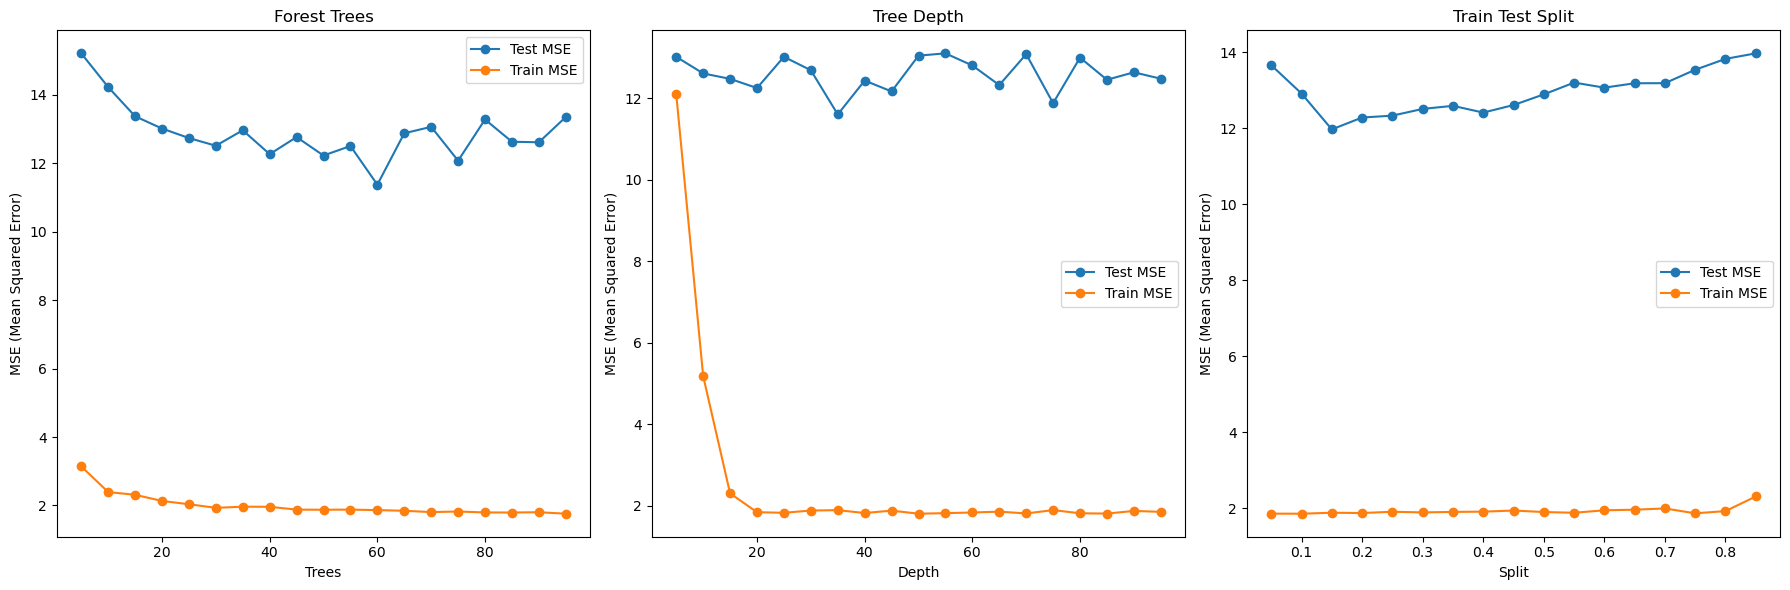

In [9]:
# Erstellen von Subplots (1 Zeile, 3 Spalten)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Forest Trees
axs[0].plot(estimators_range, estimators_mse_test, marker='o', label='Test MSE')
axs[0].plot(estimators_range, estimators_mse_train, marker='o', label='Train MSE')
axs[0].set_ylabel('MSE (Mean Squared Error)')
axs[0].set_xlabel('Trees')
axs[0].set_title('Forest Trees')
axs[0].legend()

# Plot 2: Tree Depth
axs[1].plot(depth_range, depth_mse_test, marker='o', label='Test MSE')
axs[1].plot(depth_range, depth_mse_train, marker='o', label='Train MSE')
axs[1].set_ylabel('MSE (Mean Squared Error)')
axs[1].set_xlabel('Depth')
axs[1].set_title('Tree Depth')
axs[1].legend()

# Plot 3: Train Test Split
axs[2].plot([split/100 for split in split_range], split_mse_test, marker='o', label='Test MSE')
axs[2].plot([split/100 for split in split_range], split_mse_train, marker='o', label='Train MSE')
axs[2].set_ylabel('MSE (Mean Squared Error)')
axs[2].set_xlabel('Split')
axs[2].set_title('Train Test Split')
axs[2].legend()

# Layout anpassen
plt.tight_layout()
plt.show()

In [10]:

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Initialisieren des Random Forest Regressors
rf_regressor = RandomForestRegressor(n_estimators=80, n_jobs=-1, max_depth=20)
    
# Trainieren des Regressors mit den Trainingsdaten
rf_regressor.fit(X_train, y_train)
    
# Vorhersagen auf den Testdaten
y_pred_test = rf_regressor.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)
    
# Auswertung des Modells (z.B. Mean Squared Error für Regression)
print("RMSE Vortag:" + str(mean_squared_error(Y_Daten, X_Daten[f'straubing_LUFTTEMPERATUR_{vergangenheit}'])))
print("RMSE Test:  " + str(mean_squared_error(y_test, y_pred_test)))
print("RMSE Train: " + str(mean_squared_error(y_train, y_pred_train)))

RMSE Vortag:17.361999681832643
RMSE Test:  11.415019001603463
RMSE Train: 1.850381050616307


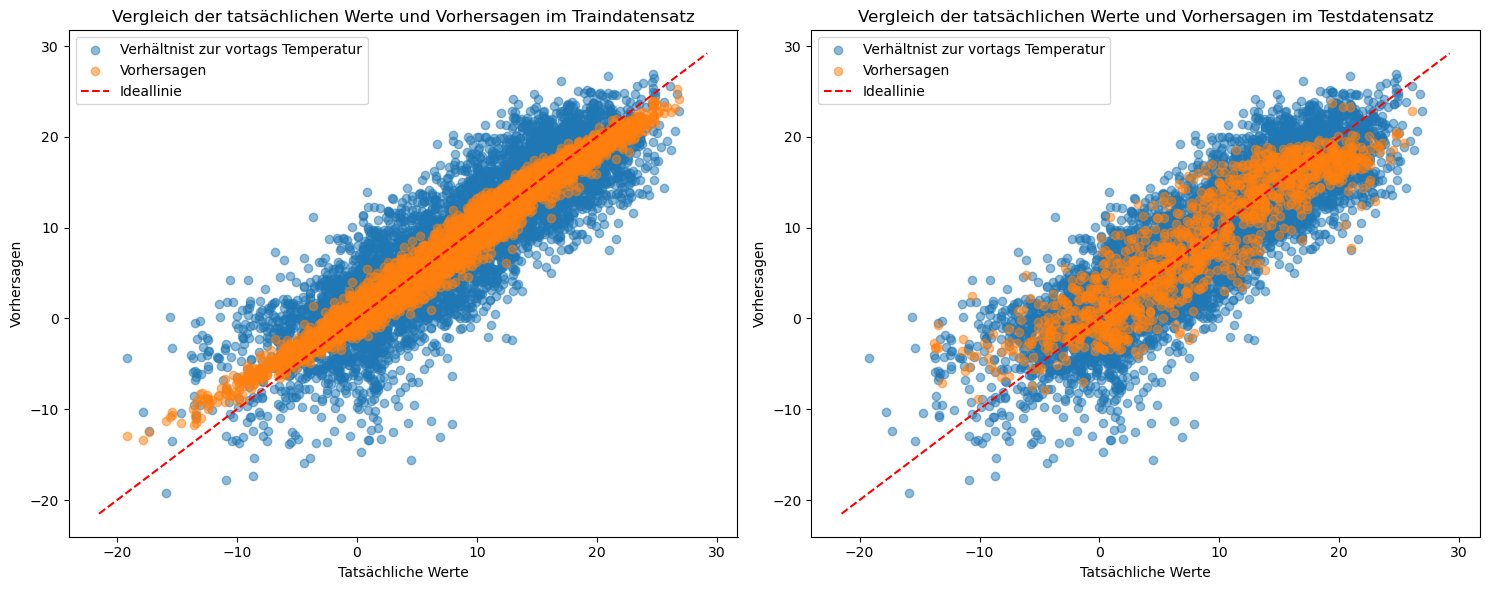

In [11]:
# Scatterplots nebeneinander darstellen
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot im Traindatensatz
axs[0].scatter(Y_Daten, X_Daten[f'straubing_LUFTTEMPERATUR_{vergangenheit}'], alpha=0.5, label='Verhältnist zur vortags Temperatur')
axs[0].scatter(y_train, y_pred_train, alpha=0.5, label='Vorhersagen')
axs[0].plot(axs[0].get_xlim(), axs[0].get_xlim(), color='red', linestyle='--', label='Ideallinie')
axs[0].set_xlabel('Tatsächliche Werte')
axs[0].set_ylabel('Vorhersagen')
axs[0].set_title('Vergleich der tatsächlichen Werte und Vorhersagen im Traindatensatz')
axs[0].legend()

# Scatterplot im Testdatensatz
axs[1].scatter(Y_Daten, X_Daten[f'straubing_LUFTTEMPERATUR_{vergangenheit}'], alpha=0.5, label='Verhältnist zur vortags Temperatur')
axs[1].scatter(y_test, y_pred_test, alpha=0.5, label='Vorhersagen')
axs[1].plot(axs[1].get_xlim(), axs[1].get_xlim(), color='red', linestyle='--', label='Ideallinie')
axs[1].set_xlabel('Tatsächliche Werte')
axs[1].set_ylabel('Vorhersagen')
axs[1].set_title('Vergleich der tatsächlichen Werte und Vorhersagen im Testdatensatz')
axs[1].legend()

plt.tight_layout()
plt.show()

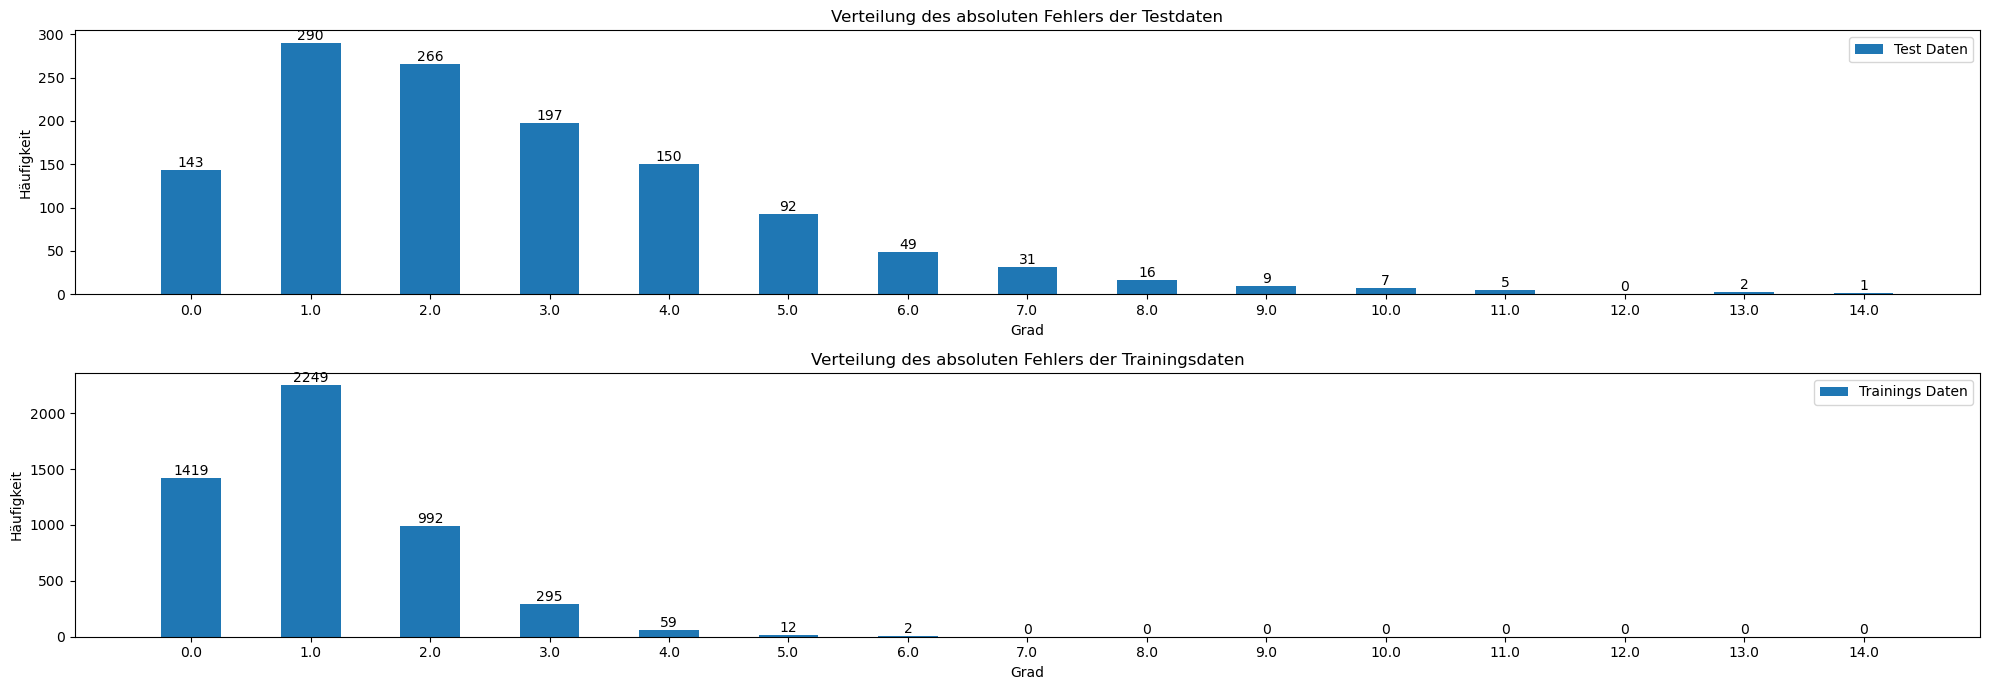

In [12]:
# Unterschied der Arrays berechnen
runden = 1
diff_array_test = np.abs(np.round(y_test * runden) / runden - np.round(y_pred_test * runden) / runden)
diff_array_train = np.abs(np.round(y_train * runden) / runden - np.round(y_pred_train * runden) / runden)

unique_elements_test, counts_test = np.unique(diff_array_test, return_counts=True)
unique_elements_train, counts_train = np.unique(diff_array_train, return_counts=True)

# Werte-Bereich mit dem gewünschten Abstand erstellen
max_value = max(max(unique_elements_test), max(unique_elements_train))
def expand(min, max, step, val, count):
    all_values = np.arange(min, max + step, step)
    # Index-Array für vorhandene Werte erstellen
    existing_values_idx = np.isin(all_values, val)
    # Fehlende Werte mit Häufigkeit 0 einfügen
    all_frequencies = np.zeros_like(all_values, dtype=int)
    all_frequencies[existing_values_idx] = count
    return (all_values, all_frequencies)

unique_elements_test, counts_test = expand(0, max_value, 1/runden, unique_elements_test, counts_test)
unique_elements_train, counts_train = expand(0, max_value, 1/runden, unique_elements_train, counts_train)


# Verteilung plotten als Bar Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))

# Breite der Bars
bar_width = 0.5

# Positionen der x-Ticks für die beiden Gruppen
x_ticks_test = np.arange(len(unique_elements_test))
x_ticks_train = np.arange(len(unique_elements_train))

# Plot für Testdaten
bar_test = ax1.bar(x_ticks_test, counts_test, width=bar_width, label="Test Daten")
ax1.set_xlabel('Grad')
ax1.set_ylabel('Häufigkeit')
ax1.set_xticks(x_ticks_test)
ax1.set_xticklabels(unique_elements_test)
ax1.legend()
ax1.set_title('Verteilung des absoluten Fehlers der Testdaten')

# Text über den Bars anzeigen
for bar, counts in zip(bar_test, counts_test):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{counts}', 
            ha='center', va='bottom')

# Plot für Trainingsdaten
bar_train = ax2.bar(x_ticks_train, counts_train, width=bar_width, label="Trainings Daten")
ax2.set_xlabel('Grad')
ax2.set_ylabel('Häufigkeit')
ax2.set_xticks(x_ticks_train)
ax2.set_xticklabels(unique_elements_train)
ax2.legend()
ax2.set_title('Verteilung des absoluten Fehlers der Trainingsdaten')

# Text über den Bars anzeigen
for bar, counts in zip(bar_train, counts_train):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{counts}', 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

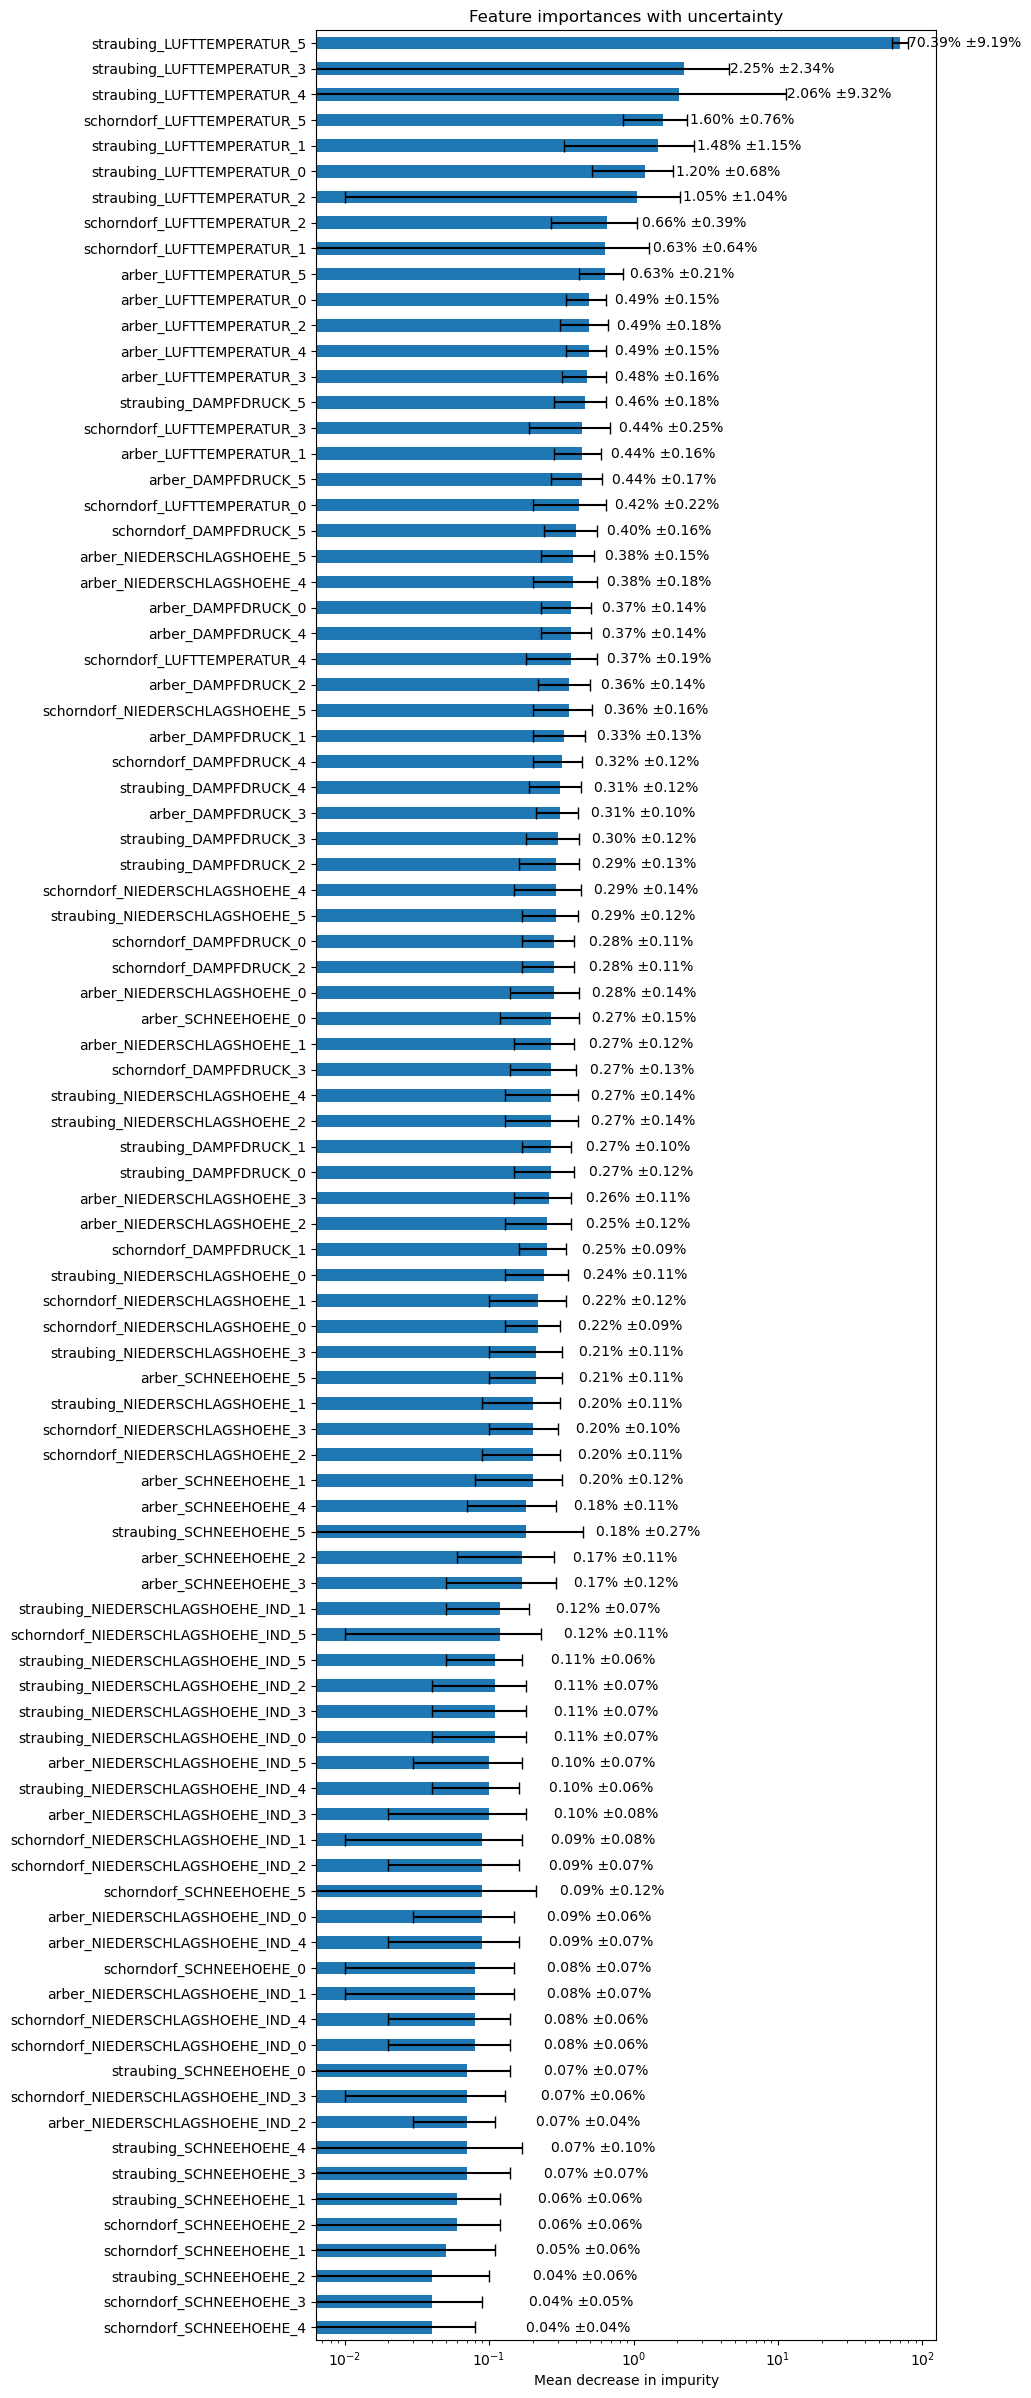

In [13]:
# Extrahieren der Importance der Trees
importances = np.round(rf_regressor.feature_importances_*100, 2)
std = np.round(np.std([tree.feature_importances_ for tree in rf_regressor.estimators_], axis=0)*100, 2)

# Indizes der sortierten Importance-Werte
sorted_indices = np.argsort(importances)

# Sortieren der Importance und Standardabweichung
importances = importances[sorted_indices]
std = std[sorted_indices]

forest_importances = pd.Series(importances, index=X_Daten.columns[sorted_indices])

# Breite des Bildes anpassen
fig, ax = plt.subplots(figsize=(8, 30))

# Balkenplot mit Fehlerbalken
forest_importances.plot.barh(xerr=std, ax=ax, capsize=4)

# Titel und Achsenbeschriftungen
ax.set_title("Feature importances with uncertainty")
ax.set_xlabel("Mean decrease in impurity")

# Logarithmische Skala für die x-Achse
ax.set_xscale('log')

# Werte neben den Balken anzeigen
for i, (feature, importance, uncertainty) in enumerate(zip(forest_importances.index, forest_importances.values, std)):
    ax.text(importance + uncertainty + 0.1, i, f'{importance:.2f}% ±{uncertainty:.2f}%', ha='left', va='center')

plt.show()